In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 使用较稳定的中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

# 读取数据
price_data = pd.read_excel('E:/360MoveData/Users/Administrator/Desktop/price.xlsx', usecols=['price(10k,yuan)', 'area_p', 'location_p'])  # 仅保留必要列
rent_data = pd.read_excel('E:/360MoveData/Users/Administrator/Desktop/rent.xlsx', usecols=['rent(yuan/month)', 'area_r', 'location_r'])

# 转换数据类型（避免多次转换）
price_data = price_data.dropna().astype({'price(10k,yuan)': float, 'area_p': float})
rent_data = rent_data.dropna().astype({'rent(yuan/month)': float, 'area_r': float})

# 计算房价/m² 和 租金/m²
price_data['price_per_m2'] = price_data['price(10k,yuan)'] * 10000 / price_data['area_p']
rent_data['rent_per_m2'] = rent_data['rent(yuan/month)'] / rent_data['area_r']

# 合并数据，减少不必要的列
merged_data = pd.merge(
    price_data[['area_p', 'price_per_m2', 'location_p']],
    rent_data[['area_r', 'rent_per_m2', 'location_r']],
    left_on='location_p', right_on='location_r', how='inner'
).drop(columns=['location_r']).rename(columns={'location_p': 'location'})

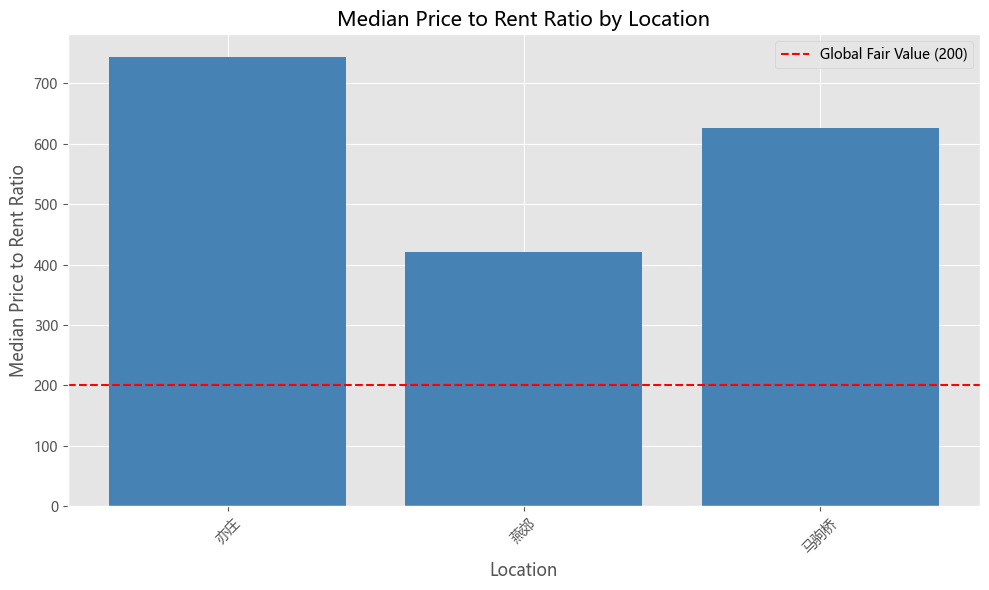

In [2]:
# 计算每个区块的中位数租售比
merged_data['price_to_rent_ratio'] = merged_data['price_per_m2'] / merged_data['rent_per_m2']
median_ratio = merged_data.groupby('location')['price_to_rent_ratio'].median()

# 绘制中位数租售比柱状图
plt.figure(figsize=(10, 6))
plt.bar(median_ratio.index, median_ratio.values, color='steelblue')
plt.axhline(200, color='r', linestyle='--', label='Global Fair Value (200)')
plt.xlabel('Location')
plt.ylabel('Median Price to Rent Ratio')
plt.title('Median Price to Rent Ratio by Location')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
# 构建 OLS 模型
model1 = smf.ols('price_per_m2 ~ area_p + C(location)', data=merged_data).fit()
model2 = smf.ols('rent_per_m2 ~ area_r + C(location)', data=merged_data).fit()

# 预测房价与租金
locations = ['马驹桥', '燕郊', '亦庄']
predict_m2_values = [50, 100]
predicted_data = []

print("\n===== 预测房价与租金（单位：元/m²） =====")

for loc in locations:
    predict_m2 = pd.DataFrame({'area_p': predict_m2_values, 'area_r': predict_m2_values, 'location': [loc] * 2})
    predicted_price = model1.predict(predict_m2)
    predicted_rent = model2.predict(predict_m2)
    predicted_ratio = predicted_price / predicted_rent

    for i in range(len(predict_m2_values)):
        predicted_data.append([predict_m2_values[i], loc, predicted_price.iloc[i], predicted_rent.iloc[i], predicted_ratio.iloc[i]])
        print(f"地点: {loc}，面积: {predict_m2_values[i]}m²，"
              f"预测房价: {predicted_price.iloc[i]:.2f} 元/m²，"
              f"预测租金: {predicted_rent.iloc[i]:.2f} 元/m²，"
              f"预测租售比: {predicted_ratio.iloc[i]:.2f}")

# 转换为 DataFrame
predicted_df = pd.DataFrame(predicted_data, columns=['area', 'location', 'predicted_price', 'predicted_rent', 'predicted_ratio'])


===== 预测房价与租金（单位：元/m²） =====
地点: 马驹桥，面积: 50m²，预测房价: 29362.38 元/m²，预测租金: 51.26 元/m²，预测租售比: 572.87
地点: 马驹桥，面积: 100m²，预测房价: 32006.07 元/m²，预测租金: 53.79 元/m²，预测租售比: 595.02
地点: 燕郊，面积: 50m²，预测房价: 8504.11 元/m²，预测租金: 21.39 元/m²，预测租售比: 397.55
地点: 燕郊，面积: 100m²，预测房价: 11147.80 元/m²，预测租金: 23.93 元/m²，预测租售比: 465.93
地点: 亦庄，面积: 50m²，预测房价: 54139.00 元/m²，预测租金: 77.48 元/m²，预测租售比: 698.79
地点: 亦庄，面积: 100m²，预测房价: 56782.69 元/m²，预测租金: 80.01 元/m²，预测租售比: 709.69


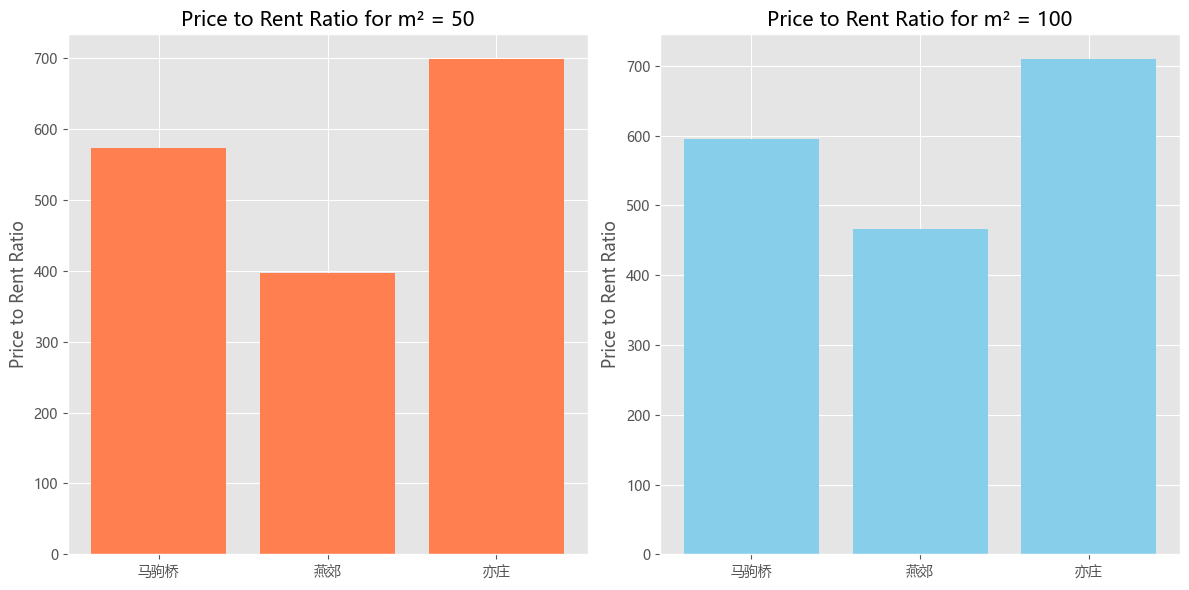

In [4]:
# 绘制预测的租售比柱状图
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Figure B: price/rent ratio for m² = 50
ax[0].bar(predicted_df[predicted_df['area'] == 50]['location'], predicted_df[predicted_df['area'] == 50]['predicted_ratio'], color='coral')
ax[0].set_title('Price to Rent Ratio for m² = 50')
ax[0].set_ylabel('Price to Rent Ratio')

# Figure C: price/rent ratio for m² = 100
ax[1].bar(predicted_df[predicted_df['area'] == 100]['location'], predicted_df[predicted_df['area'] == 100]['predicted_ratio'], color='skyblue')
ax[1].set_title('Price to Rent Ratio for m² = 100')
ax[1].set_ylabel('Price to Rent Ratio')

plt.tight_layout()
plt.show()